In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import numpy.random as random

# Dimensionality reduction package
from scipy.stats import pointbiserialr
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import TSNE
!pip install -q umap-learn[plot]
import umap

#importing clustering packages
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

#
%matplotlib inline

**General descriptive statistics on each variable**

In [57]:
# load data
df=pd.read_csv("./processed_df.csv")
df=df.drop(columns=["Unnamed: 0"])
df_raw=pd.read_csv("./MBA 2.csv")

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6094 entries, 0 to 6093
Data columns (total 28 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gpa                             6094 non-null   float64
 1   gmat                            6094 non-null   float64
 2   work_exp                        6094 non-null   float64
 3   is_male                         6094 non-null   float64
 4   is_international                6094 non-null   float64
 5   accepted                        6094 non-null   float64
 6   major_Business                  6094 non-null   float64
 7   major_Humanities                6094 non-null   float64
 8   major_STEM                      6094 non-null   float64
 9   Asian                           6094 non-null   float64
 10  Black                           6094 non-null   float64
 11  Hispanic                        6094 non-null   float64
 12  Other                           60

In [47]:
df_raw.describe()

,application_id,gpa,gmat,work_exp
count,6194.000000,6194.000000,6194.000000,6194.000000
mean,3097.500000,3.250714,651.092993,5.016952
std,1788.198115,0.151541,49.294883,1.032432
min,1.000000,2.650000,570.000000,1.000000
25%,1549.250000,3.150000,610.000000,4.000000
50%,3097.500000,3.250000,650.000000,5.000000
75%,4645.750000,3.350000,680.000000,6.000000
max,6194.000000,3.770000,780.000000,9.000000


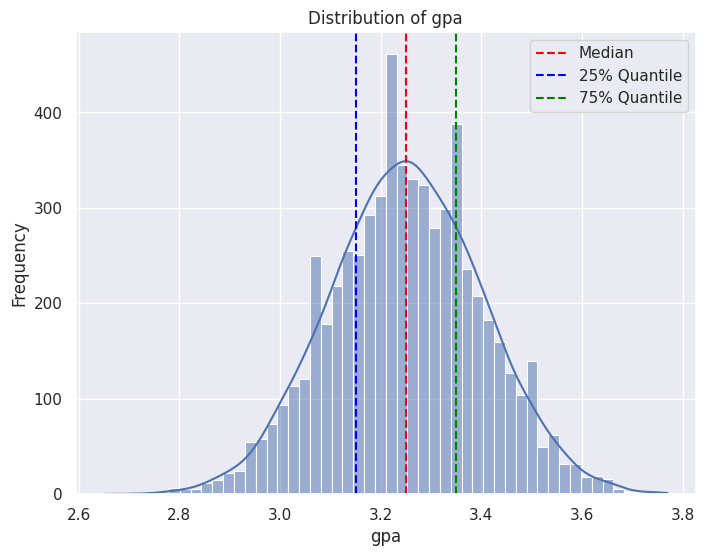

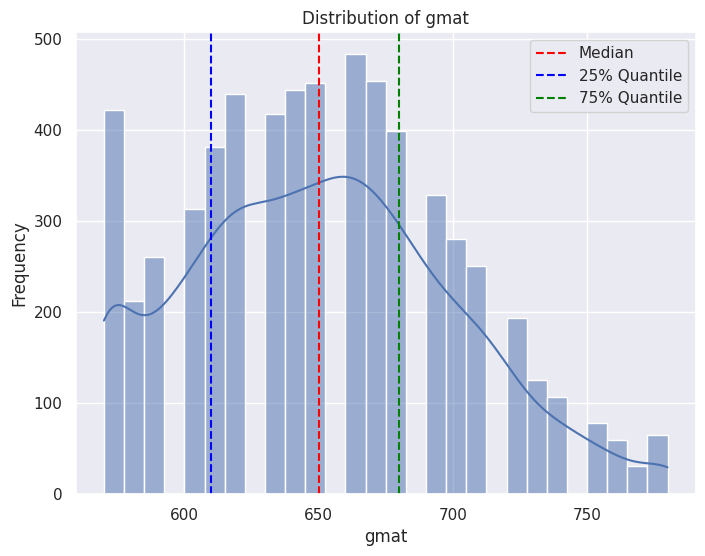

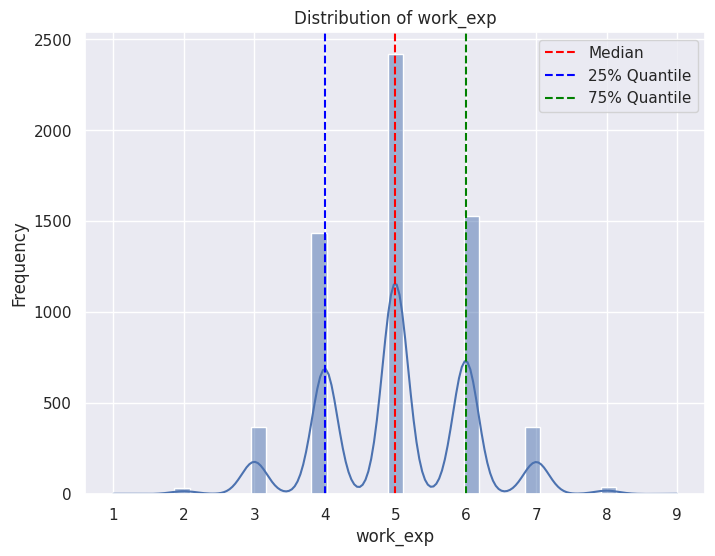

In [69]:
# For continuous variables
continouse_Var = ['gpa', 'gmat', 'work_exp']
sns.set_theme()

for col in continouse_Var:
    # Calculate statistics
    median = df_raw[col].median()
    q25 = df_raw[col].quantile(0.25)
    q75 = df_raw[col].quantile(0.75)

    plt.figure(figsize=(8, 6))
    sns.histplot(df_raw[col], kde=True)

    # Add vertical lines
    plt.axvline(median, color='red', linestyle='--', label='Median')
    plt.axvline(q25, color='blue', linestyle='--', label='25% Quantile')
    plt.axvline(q75, color='green', linestyle='--', label='75% Quantile')

    plt.legend()
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()


In [27]:
# Categorical variables
catergorical = ['gender','major','race','work_industry','international']
stats_cate = df_raw[catergorical].describe()
stats_cate

,gender,major,race,work_industry,international
count,6194,6194,4352,6194,6194
unique,2,3,5,14,2
top,Male,Humanities,White,Consulting,False
freq,3943,2481,1456,1619,4352


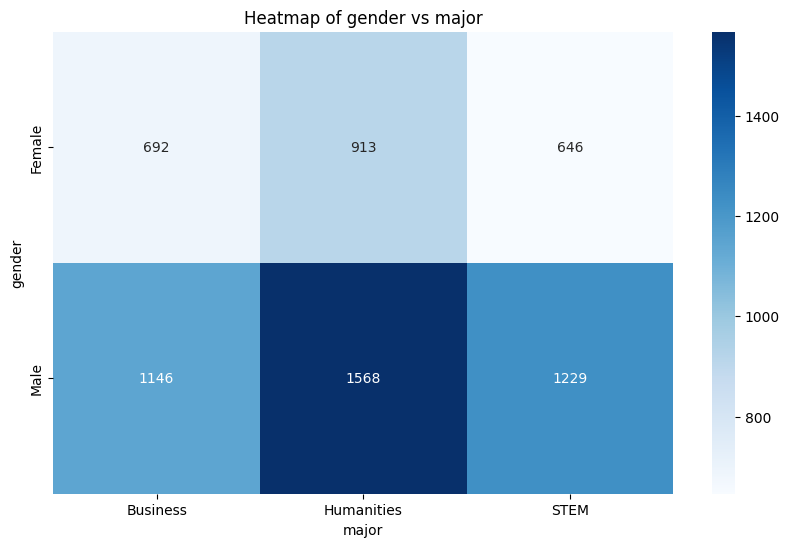

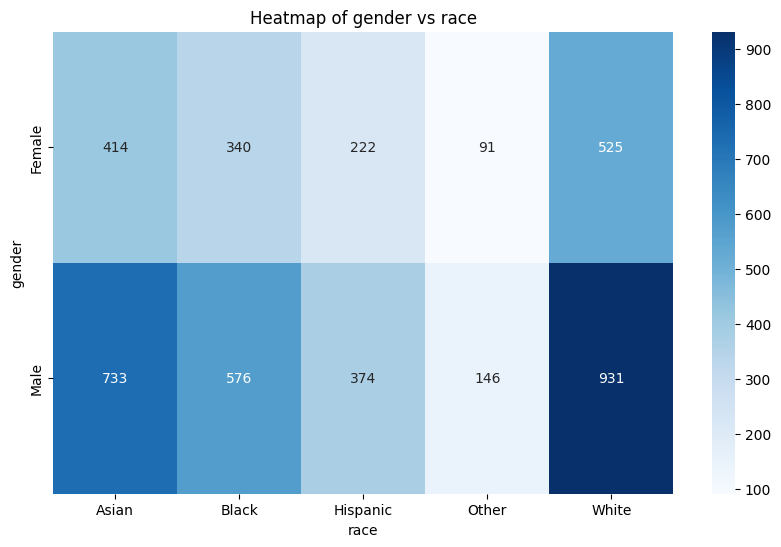

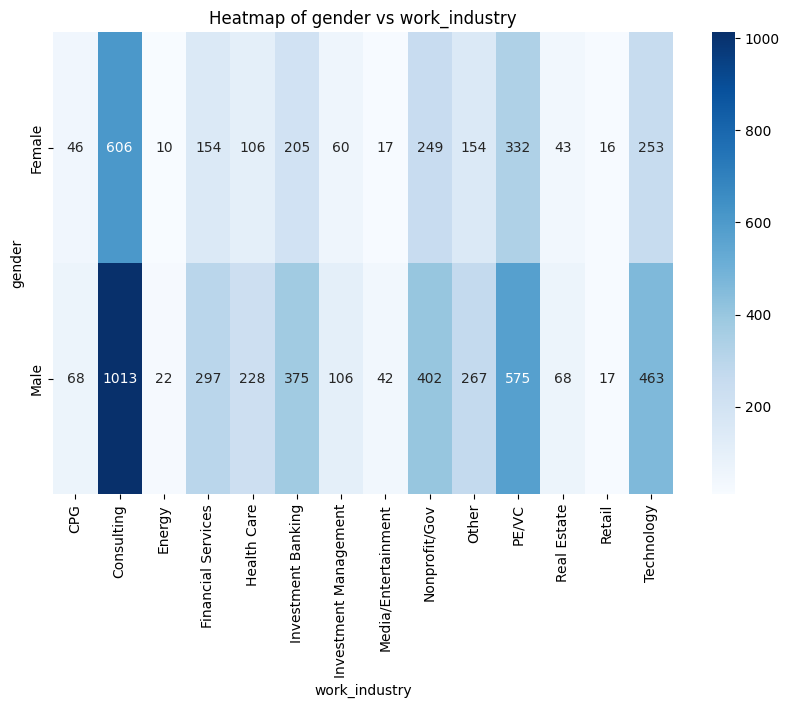

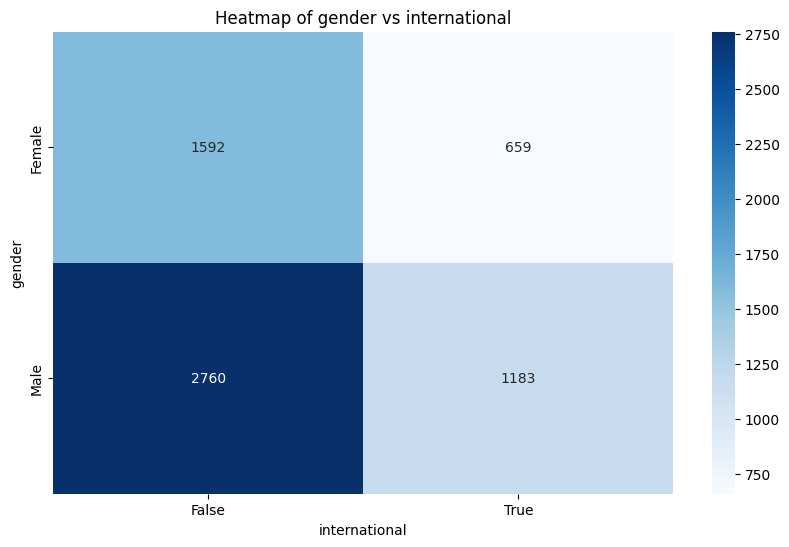

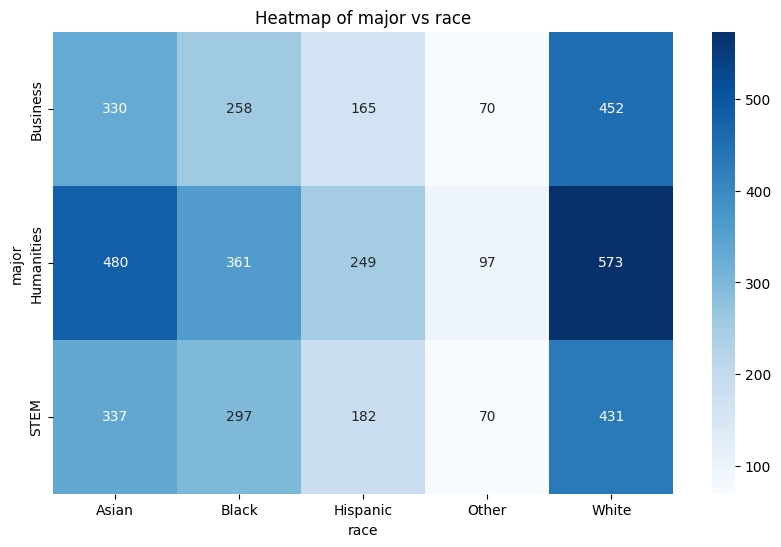

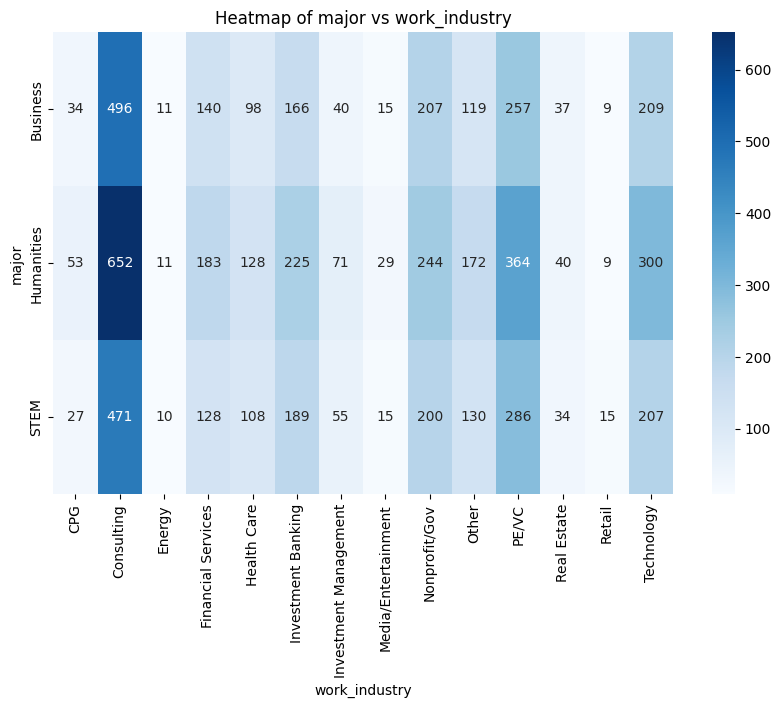

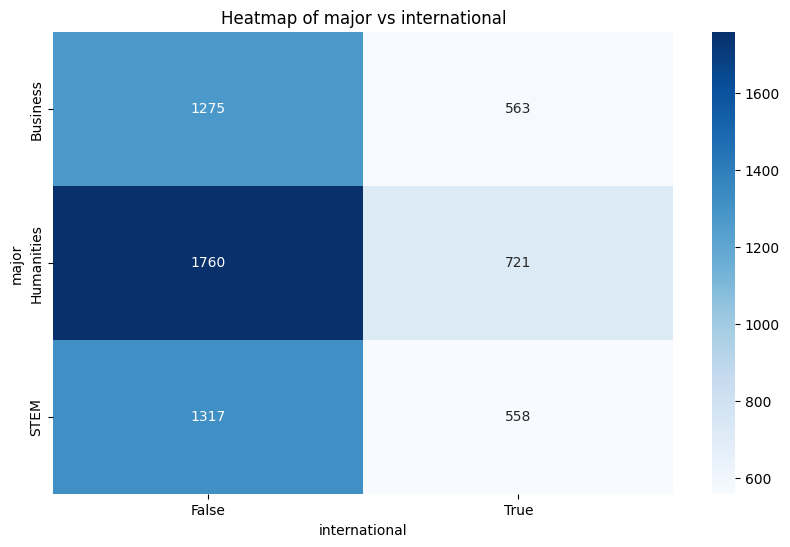

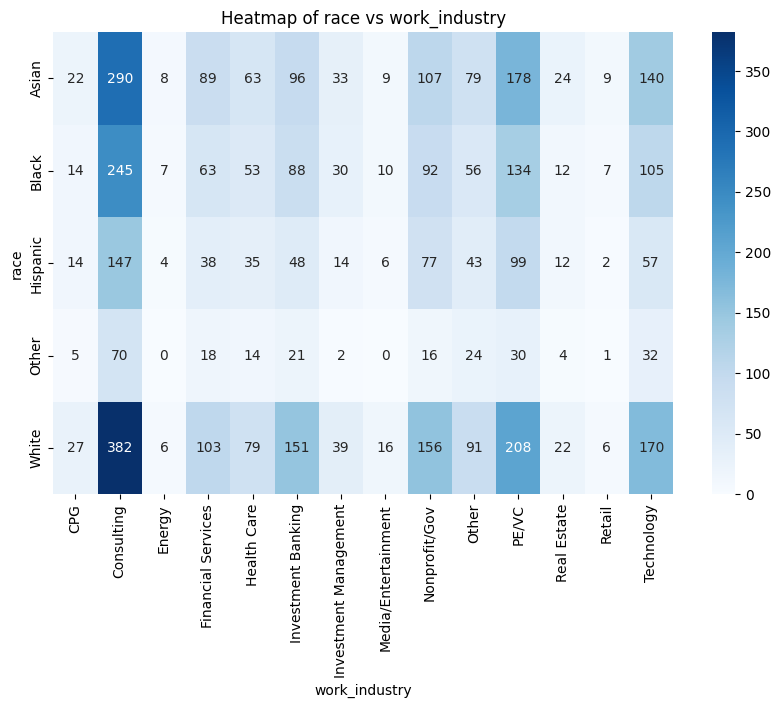

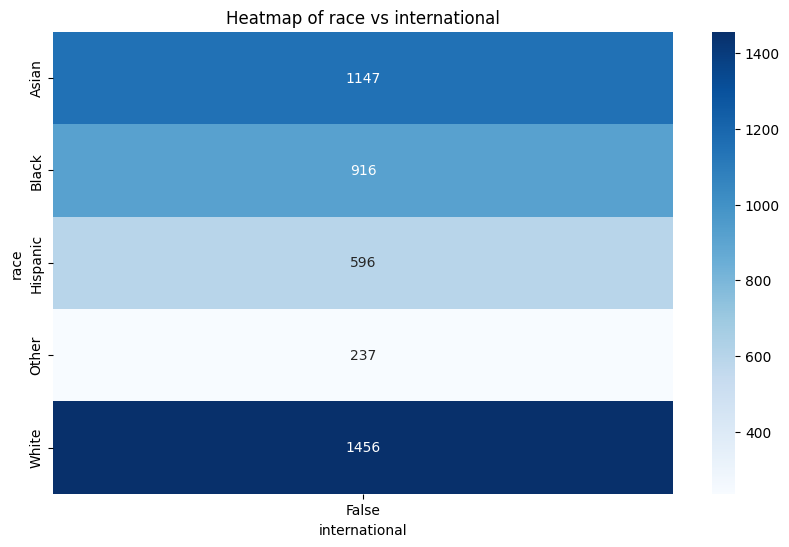

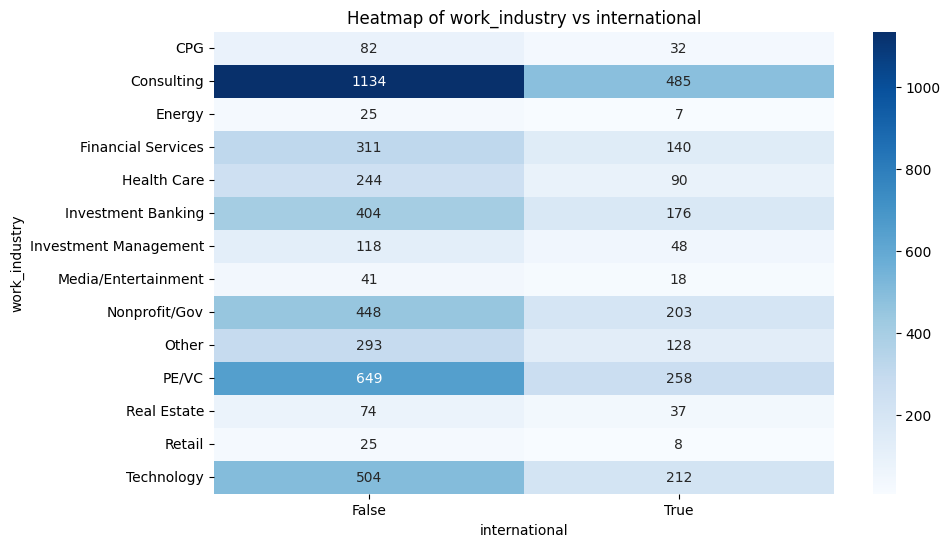

In [28]:
# Heatmap for catgorical data
for i, col1 in enumerate(catergorical):
    for j, col2 in enumerate(catergorical):
        if i < j:  # Avoid redundant plots
            # Create a cross-tabulation
            crosstab = pd.crosstab(df_raw[col1], df_raw[col2])

            plt.figure(figsize=(10, 6))
            sns.heatmap(crosstab, annot=True, fmt="d", cmap="Blues")
            plt.title(f"Heatmap of {col1} vs {col2}")
            plt.xlabel(col2)
            plt.ylabel(col1)
            plt.show()


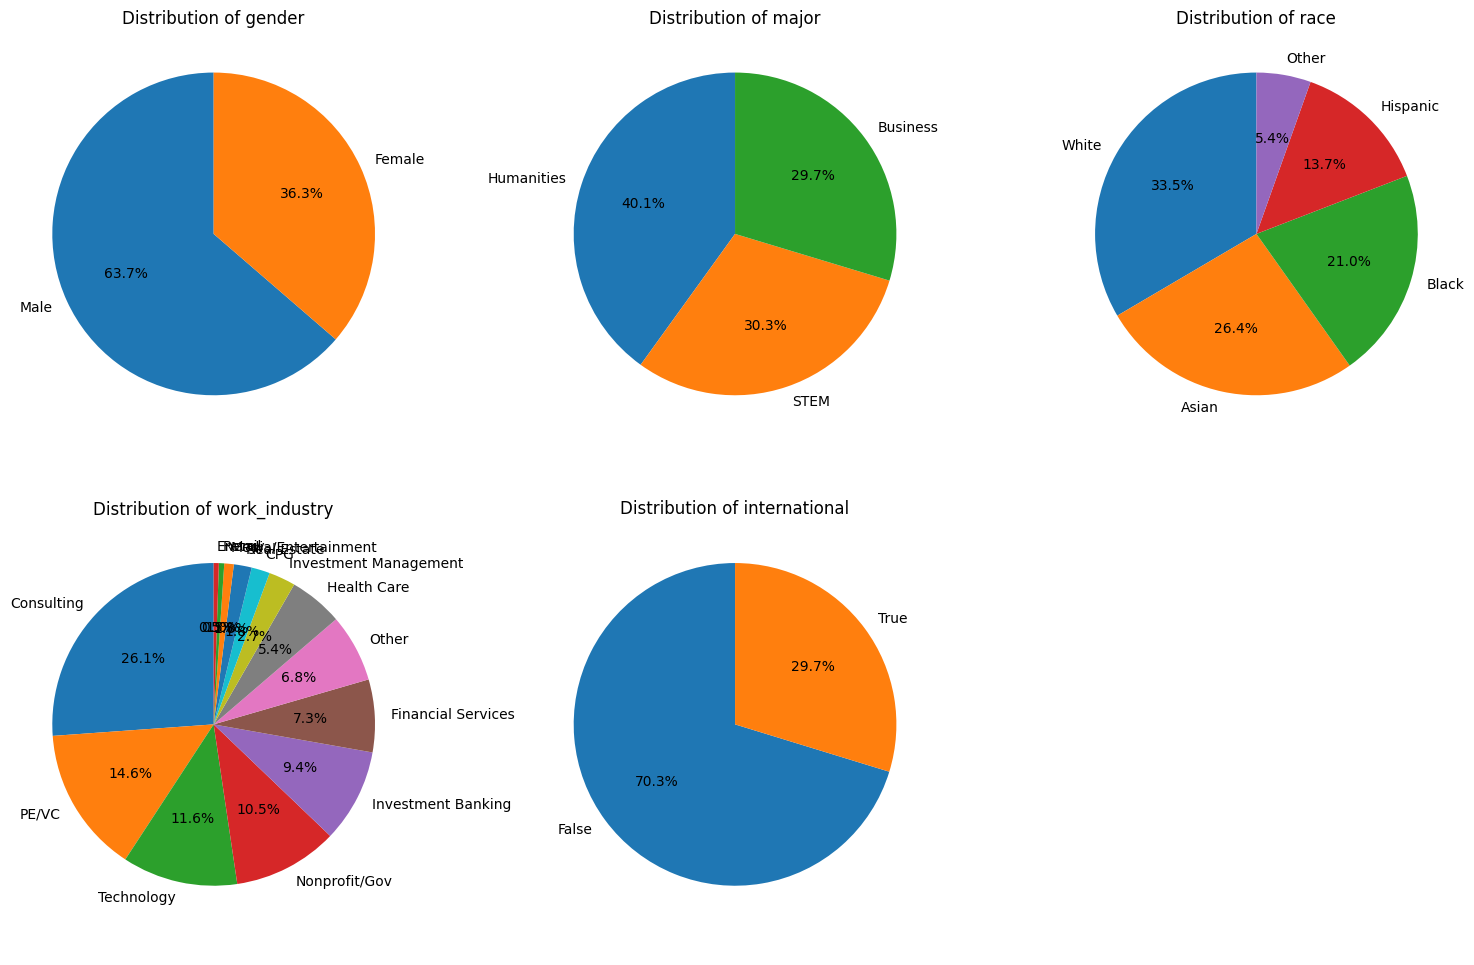

In [31]:
# Pie chart for each categorical variable
ncols = 3
nrows = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(catergorical):
    value_counts = df_raw[col].value_counts()
    axes[i].pie(value_counts, autopct='%1.1f%%', startangle=90, colors=plt.cm.tab10.colors, labels=value_counts.index)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_ylabel('')  # Remove y-axis label
# hide unused
for j in range(len(catergorical), len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()

<ipython-input-91-c027533dc7cc>:44: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_matrix = corr_matrix.applymap(lambda x: f"{x:.1f}" if abs(x) > threshold else "")


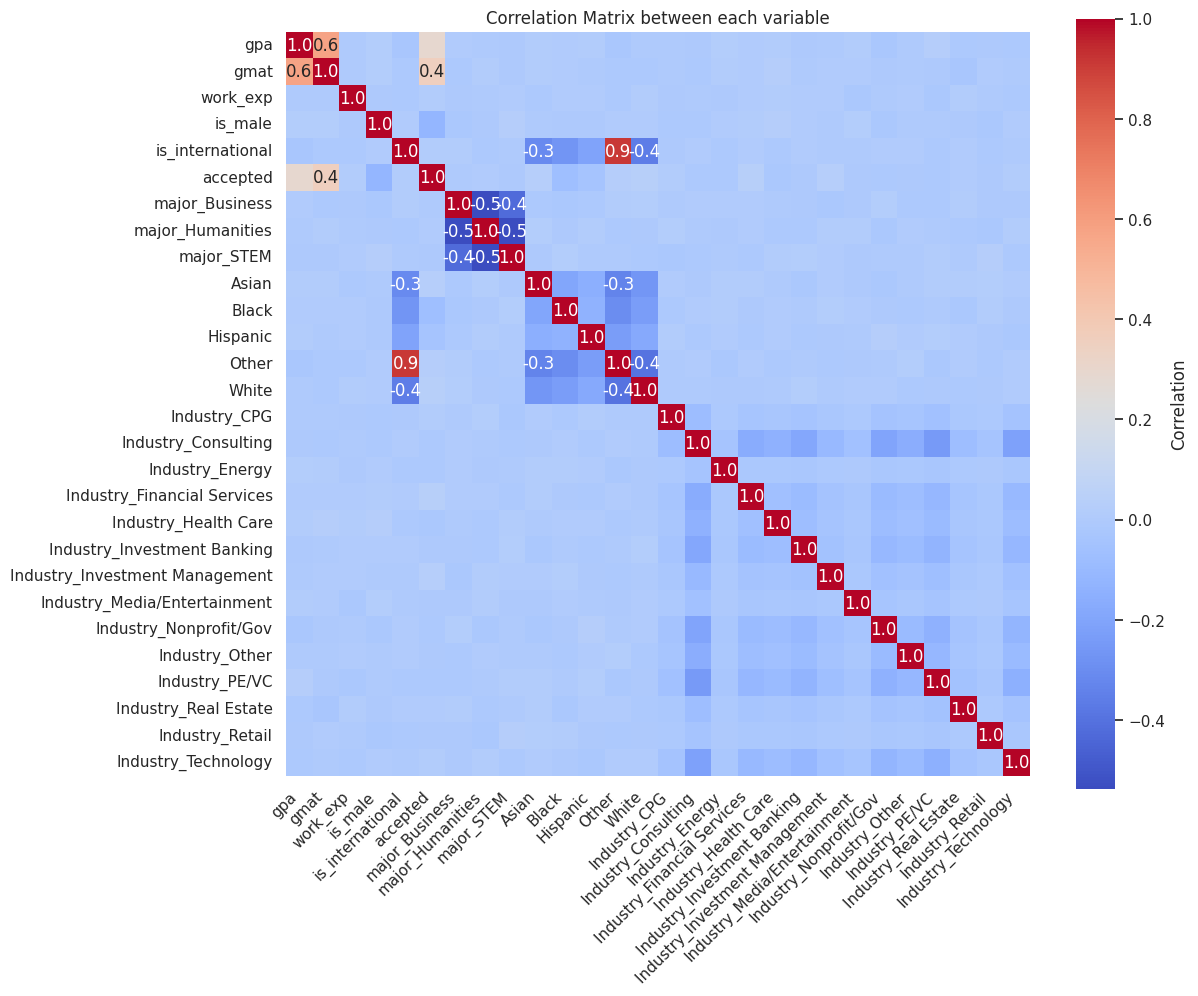

In [91]:
## Correlation between ALL variables
def calculate_correlation_matrix(df):
    # Separate numerical and categorical columns
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols = [col for col in df.columns if col not in numerical_cols]

    # Initialize correlation matrix
    corr_matrix = pd.DataFrame(index=df.columns, columns=df.columns)

    # Compute correlations
    for col1 in df.columns:
        for col2 in df.columns:
            if col1 in numerical_cols and col2 in numerical_cols:
                # Pearson correlation for numerical variables
                corr_matrix.loc[col1, col2] = df[col1].corr(df[col2])
            elif col1 in categorical_cols and col2 in categorical_cols:
                # Cramér's V for categorical variables
                confusion_matrix = pd.crosstab(df[col1], df[col2])
                chi2 = np.sum((confusion_matrix - np.outer(confusion_matrix.sum(axis=1),
                                                           confusion_matrix.sum(axis=0)) / df.shape[0]) ** 2 /
                              (np.outer(confusion_matrix.sum(axis=1), confusion_matrix.sum(axis=0)) / df.shape[0]))
                corr_matrix.loc[col1, col2] = np.sqrt(chi2 / (df.shape[0] * (min(confusion_matrix.shape) - 1)))
            elif col1 in numerical_cols and col2 in categorical_cols:
                # Point-biserial correlation for categorical (binary) vs numerical
                if df[col2].nunique() == 2:  # Binary categorical
                    corr_matrix.loc[col1, col2] = pointbiserialr(df[col2], df[col1])[0]
                else:
                    # Encode categorical variable if not binary
                    encoded = LabelEncoder().fit_transform(df[col2])
                    corr_matrix.loc[col1, col2] = pointbiserialr(encoded, df[col1])[0]
            elif col1 in categorical_cols and col2 in numerical_cols:
                # Swap variables for point-biserial correlation
                corr_matrix.loc[col1, col2] = corr_matrix.loc[col2, col1]

    # Convert to numeric and fill NaN values
    corr_matrix = corr_matrix.astype(float).fillna(0)
    return corr_matrix

corr_matrix = calculate_correlation_matrix(df)

threshold = 0.3

# mask annotation
annot_matrix = corr_matrix.applymap(lambda x: f"{x:.1f}" if abs(x) > threshold else "")

# Plot heatmap
plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    corr_matrix,
    annot=annot_matrix,
    fmt="",
    cmap="coolwarm",
    square=True,
    cbar_kws={'label': 'Correlation'}
)

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')  # Rotate labels 45 degrees and align to the right
plt.title("Correlation Matrix between each variable")
plt.show()

**Dimensionality reduction on distance matrix: MDS, t-SNE**

In [95]:
# Calculate distance matrix for all the categorical variables
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import MinMaxScaler,StandardScaler
numerical_cols = ['gpa','gmat','work_exp']
scaler = StandardScaler()
df_DR = df.drop(columns='accepted')
df_DR[numerical_cols] = scaler.fit_transform(df[numerical_cols])
dist_matrix = squareform(pdist(df, metric='euclidean'))

sclar_dist = MinMaxScaler()
dist_matrix = sclar_dist.fit_transform(dist_matrix)

dist_matrix.shape
dist_matrix

array([[0.        , 0.65811634, 0.55391092, ..., 0.55832736, 0.5957472 ,
        0.52092056],
       [0.5142968 , 0.        , 0.48839204, ..., 0.52126858, 0.57779803,
        0.45975288],
       [0.49106898, 0.55406409, 0.        , ..., 0.28032176, 0.56305084,
        0.5757352 ],
       ...,
       [0.45803842, 0.5472218 , 0.25939837, ..., 0.        , 0.50743158,
        0.54213532],
       [0.47451423, 0.58891436, 0.50586225, ..., 0.49266503, 0.        ,
        0.53790535],
       [0.43603404, 0.49245008, 0.54358706, ..., 0.55315089, 0.56528509,
        0.        ]])

In [110]:
# k-means
from sklearn.metrics import silhouette_score


def plot_clustering_on_embedding_two(embedding, labels1, labels2, title1="Clustering Method 1", title2="Clustering Method 2"):
    """
    Function to plot two subplots showing the 2D embedding with assigned cluster labels from two different clustering methods.
    """
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))  # Create two side-by-side subplots

    # First clustering plot
    scatter1 = ax[0].scatter(embedding[:, 0], embedding[:, 1], c=labels1, cmap='Spectral', s=30, alpha=0.8)
    ax[0].set_title(title1)
    fig.colorbar(scatter1, ax=ax[0], label='Cluster Label')

    # Second clustering plot
    scatter2 = ax[1].scatter(embedding[:, 0], embedding[:, 1], c=labels2, cmap='Spectral', s=30, alpha=0.8)
    ax[1].set_title(title2)
    fig.colorbar(scatter2, ax=ax[1], label='Cluster Label')

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

def optimal_kmeans_k(embedding, max_k=10):
# Find optimal k-clusters
    silhouette_scores = []
    K = range(2, max_k + 1)

    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(embedding)
        silhouette_scores.append(silhouette_score(embedding, kmeans.labels_))

    # Plot the silhouette score to help with choosing k
    plt.figure(figsize=(8, 4))
    plt.plot(K, silhouette_scores, 'rx-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Scores for Different k')
    plt.show()

    # silhouette score
    optimal_k = K[np.argmax(silhouette_scores)]
    print(f"Optimal number of clusters (k) chosen: {optimal_k}")

    return optimal_k

def apply_kmeans_gmm(embedding):
# Applly k-means and GMM
    # Step 1: Choose optimal k for K-means using elbow method
    optimal_k = optimal_kmeans_k(embedding)

    # Step 2: Apply K-means with optimal k
    kmeans = KMeans(n_clusters=optimal_k, random_state=0)
    kmeans_labels = kmeans.fit_predict(embedding)

    # Step 3: Apply Gaussian Mixture Model (GMM) with the same number of components
    gmm = GaussianMixture(n_components=optimal_k, random_state=0)
    gmm_labels = gmm.fit_predict(embedding)

    # Step 4: Plot both clustering results
    plot_clustering_on_embedding_two(embedding, kmeans_labels, gmm_labels, title1="K-means Clustering", title2="GMM Clustering")
    return kmeans_labels, gmm_labels


Text(0, 0.5, 'MDS Dimension 2')

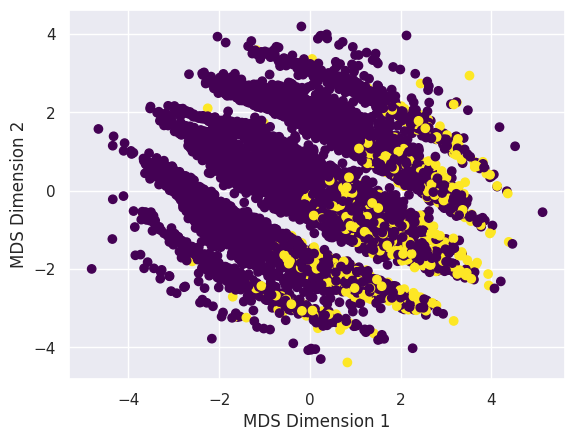

In [90]:
# mds labled with admisssion results
mds_model = MDS(n_components=2, random_state=42, dissimilarity = 'precomputed')
mds_data = mds_model.fit_transform(dist_matrix)

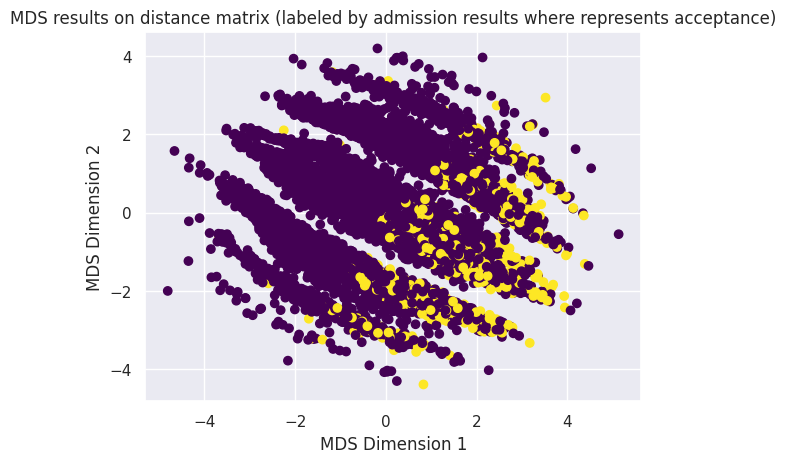

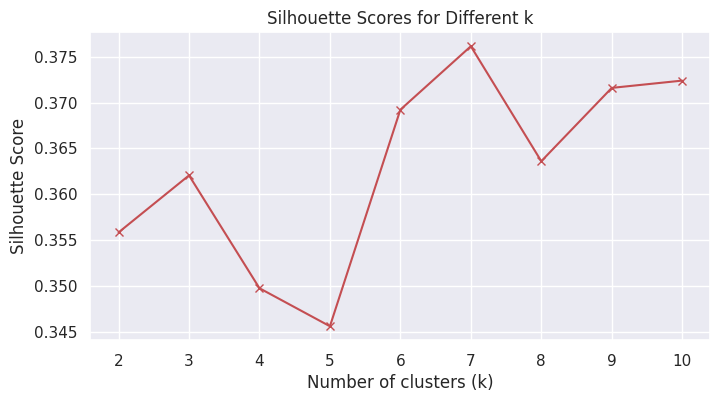

Optimal number of clusters (k) chosen: 7


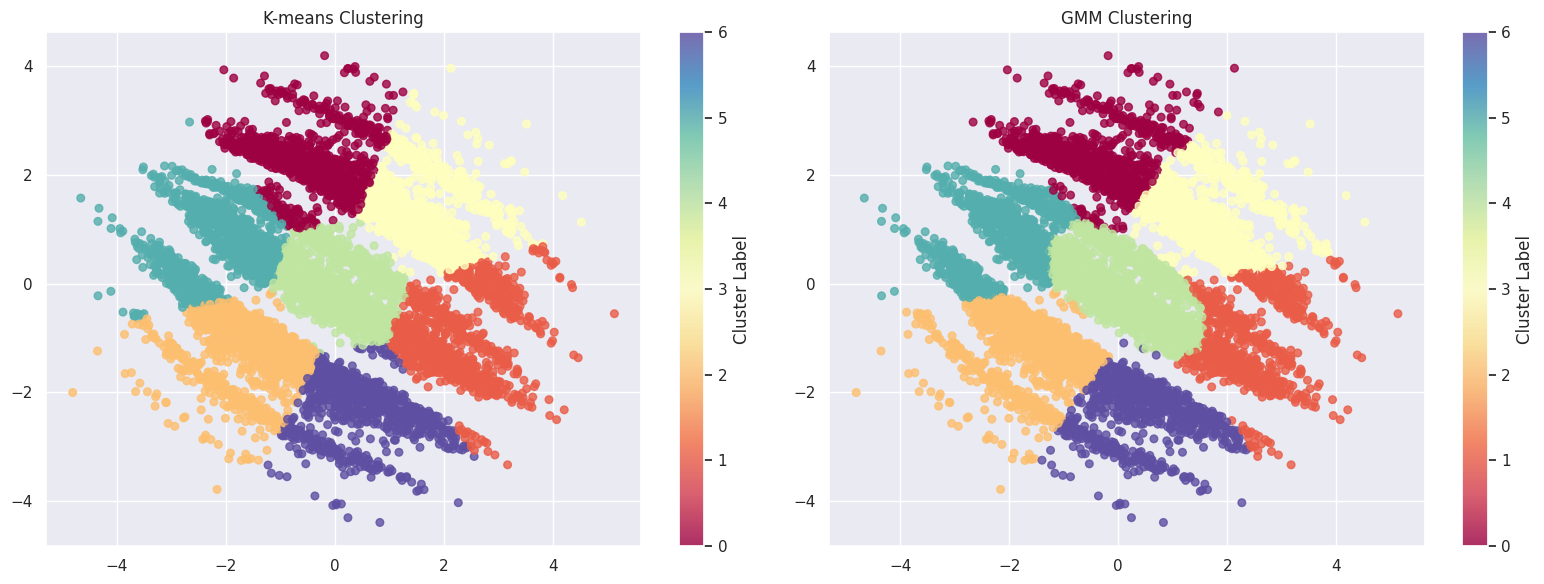

(array([3, 4, 1, ..., 4, 0, 3], dtype=int32), array([0, 4, 1, ..., 4, 0, 3]))

In [112]:
plt.scatter(mds_data[:, 0], mds_data[:, 1], c=df['accepted'], cmap='viridis')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.title('MDS results on distance matrix (labeled by admission results where represents acceptance)')
plt.show()

apply_kmeans_gmm(mds_data)

Text(0, 0.5, 't-SNE Dimension 2')

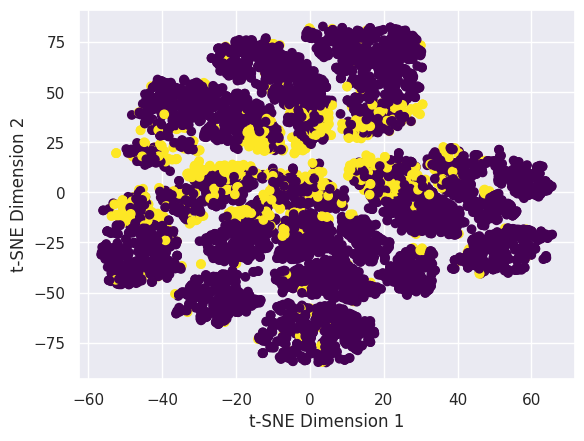

In [104]:
# t-sne
tsne_model = TSNE(n_components=2, perplexity=40,random_state=42,metric='precomputed', init='random')
tsne_data = tsne_model.fit_transform(dist_matrix)

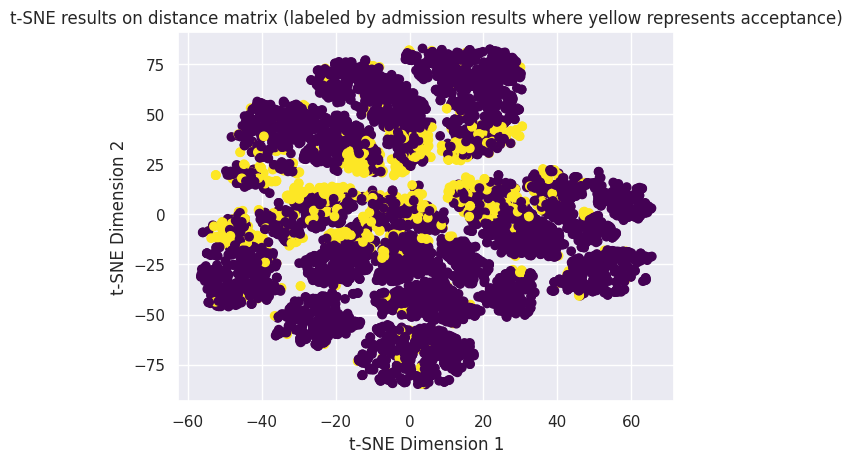

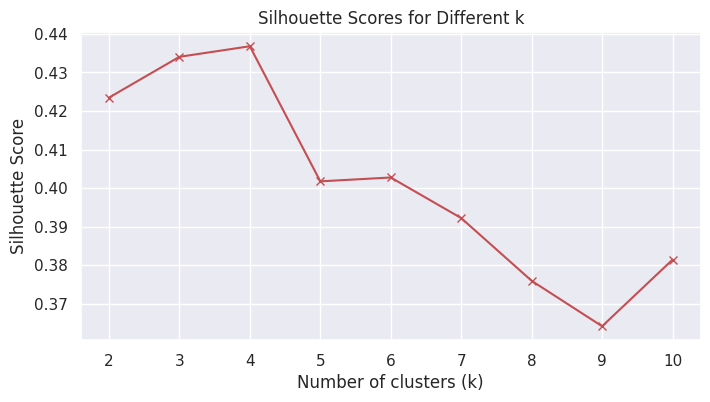

Optimal number of clusters (k) chosen: 4


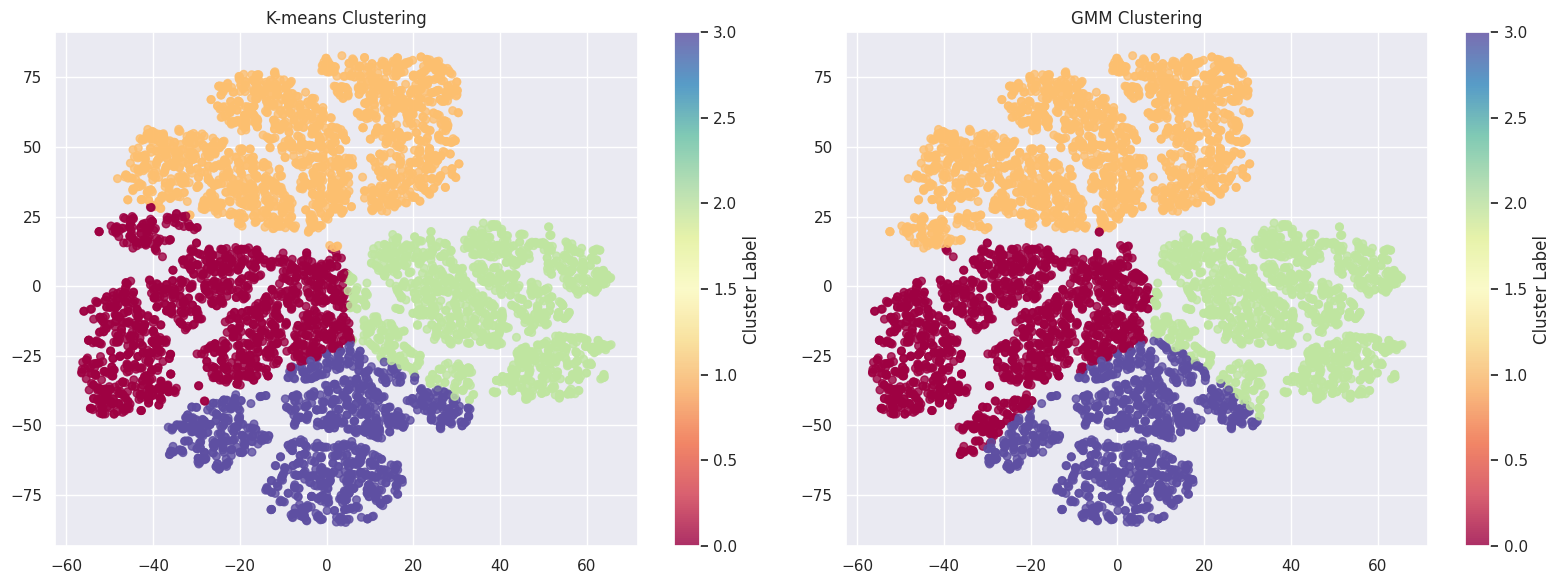

(array([0, 3, 1, ..., 1, 1, 2], dtype=int32), array([0, 0, 1, ..., 1, 1, 2]))

In [111]:
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=df['accepted'], cmap='viridis')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE results on distance matrix (labeled by admission results where yellow represents acceptance)')
plt.show()

apply_kmeans_gmm(tsne_data)